import packages needed by the codes below. Run this cell first before using these codes. 

In [119]:
import numpy as np

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline

from plotting import plot_prettier, plot_color_map
plot_prettier()


In [120]:
from astropy.cosmology import LambdaCDM
import astropy.units as u

def d_l_tilde_astropy(z, H0, Om0, OmL, clight=2.99792e5):
    '''
    compute d_l_tilde using AstroPy d_L function
    
    Parameters:
    
    z - float, or numpy array, redshift
    H0 - float, Hubble constant in km/s/Mpc
    Om0, OmL - floats, dimensionless matter and dark energy densities
    
    Returns:
    
        d_L - float, or numpy array, rescaled by c/H0 in Mpc 
    '''
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=OmL)
    
    return cosmo.luminosity_distance(z=z) / u.Mpc / (clight/H0)

In [121]:
def get_dl_train_test(ntrain=15, ntest=100, z=1.0, H0=70., 
                      om0min=0., om0max = 1., omlmin=0., omlmax=1.):
    '''
    Generate a grid of training values of d_L for a given redshift z, H0, and range
    of Om0 and OmL for specified number of training points and their spacing
    
    Parameters:
        ntrain - int, number of training points
        ntest - int, number of test points
        z - float, redshift for which to compute d_L_tilde values
        H0 - float, Hubble constant in km/s/Mpc
        om0min, om0max - floats, range of Omega_m0 values for which to generate training and test values
        omlmin, omlmax - floats, range of Omega_Lambda values 
                
    Returns:
        om0tr, omltr - 1d numpy arrays of floats, training points
        om0t, omlt   - 1d numpy arrays of floats, test points 
        dl_train, dl_test - 2d arrays of training and test values of d_L_tilde
    '''
    om0tr = np.linspace(om0min, om0max, ntrain)
    omltr = np.linspace(omlmin, omlmax, ntrain)
        
    dl_train = np.zeros((ntrain, ntrain)) # initialize 2D numpy array for 2D grid of d_L values     
    # Now cycle through Om0 and OmL values, compute d_L and fill the dlgrid array with values
    for i, omd in enumerate(om0tr):
        for j, omld in enumerate(omltr):
                dl_train[i,j] = d_l_tilde_astropy(z, H0, omd, omld)

    # test points             
    om0t = np.linspace(om0min, om0max, ntest)
    omlt = np.linspace(omlmin, omlmax, ntest)

    dl_test = np.zeros((ntest, ntest)) # initialize 2D numpy array for 2D grid of d_L values 
    # Now cycle through Om0 and OmL values, compute d_L and fill the dlgrid array with values
    for i, omd in enumerate(om0t):
        for j, omld in enumerate(omlt):
                dl_test[i,j] = d_l_tilde_astropy(z, H0, omd, omld)

    return om0tr, omltr, om0t, omlt, dl_train, dl_test

/Users/noahvirani/Downloads/plotting.py:285: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, data, cmap=cmap, rasterized=False)


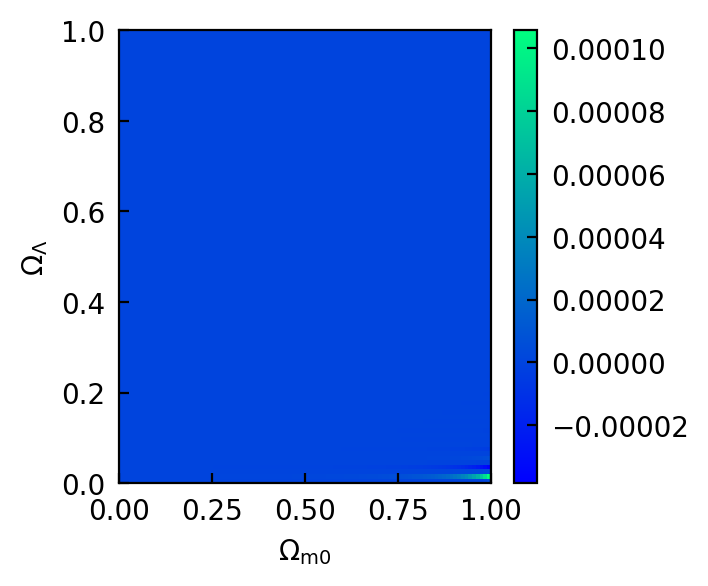

In [122]:
from scipy.interpolate import RectBivariateSpline
import numpy as np


om0tr, omltr, om0t, omlt, dl_train, dl_test = get_dl_train_test(ntrain=50, ntest=100, z=2.0, H0=70., 
                      om0min=0., om0max = 1., omlmin=0., omlmax=1.)

# create an instance of a 2d spline interpolation object
# s = 0 forces interpolation instead of regression, kx, ky set order of spline polynomials (cubic here)
spl2d = RectBivariateSpline(om0tr, omltr, dl_train, s=0, kx=3, ky=3)

# compute spline approximation values at test points defined for polynomials above
zspl = spl2d(om0t, omlt)

ferr = zspl/dl_test - 1
plot_color_map(om0t, omlt, ferr, xlim=[0,1], ylim=[0,1], 
                   xlabel = r'$\Omega_{\rm m0}$', ylabel = r'$\Omega_\Lambda$', cmap='winter', colorbar=True, 
                   figsize=3.0)



In [123]:
def polyfit2d(xtr, ytr, ftr, order=None):
    '''
    Parameters:
        xtr, ytr - 1d numpy vectors with training points of x and y
        ftr - function values at xtr, ytr values
        order - int, order of the polynomial
        
    Returns:
        coefficients of the 2D polynomial
    '''
    # generate 2d coordinates on a rectangular grid
    x, y = np.meshgrid(xtr, ytr)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((order+1, order+1))
    # array that will contain polynomial term values 
    V = np.zeros((coeffs.size, x.size))

    # construct the 2D matrix of values for each polynomial term i, j
    for index, (j, i) in enumerate(np.ndindex(coeffs.shape)):
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = x**i * y**j # coeffs[i, j] * 
        V[index] = arr.flatten() 
        
    # solve for the polynomial coefficients using least squares approximation of ftr values 
    return np.linalg.lstsq(V.T, np.ravel(ftr), rcond=None)[0]

def poly2d(xtest, ytest, a):
    '''
    Compute values of the 2D polynomial given the coefficients in 1d array a 
    at points given by 2d arrays xtest and ytest (generated using meshgrid)
    '''
    order1 = np.rint(a.size**0.5).astype(int)
    return np.polynomial.polynomial.polyval2d(xtest, ytest, a.reshape((order1,order1)))
    

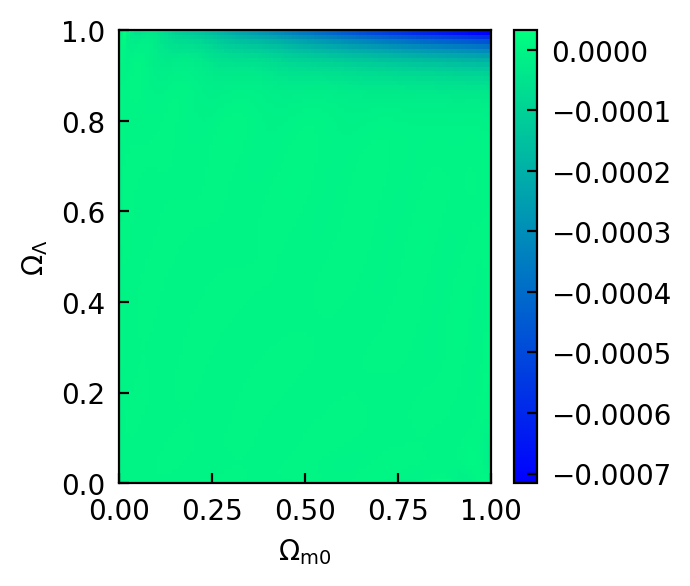

In [124]:
om0tr, omltr, om0t, omlt, dl_train, dl_test = get_dl_train_test(ntrain=60, ntest=100, z=2.0, H0=70., 
                      om0min=0., om0max = 1., omlmin=0., omlmax=1.)

poly1 = polyfit2d(om0tr, omltr, dl_train, order=20)

om0t2, omlt2 = np.meshgrid(om0t, omlt)
poly2 = poly2d(om0t2, omlt2, poly1)

ferr2 = poly2/dl_test.T - 1
plot_color_map(om0t, omlt, ferr2, xlim=[0,1], ylim=[0,1], 
                   xlabel = r'$\Omega_{\rm m0}$', ylabel = r'$\Omega_\Lambda$', cmap='winter', colorbar=True, 
                   figsize=3.0)



Number of Training Points: 60

In [125]:
npop = 10 # number of population members 
inds = np.arange(npop) # create a list of indices from 0 to npop-1
inds = np.delete(inds,7) # remove specific index 7 from inds
np.random.shuffle(inds) # shuffle indices randomly
print(inds[0], inds[1], inds[2]) # print the first 3 of the shuffled indices

0 1 5


In [129]:
def minimize_de(func, x0, atol=1.e-6, s=0.1, bounds=None):
    xnow = np.copy(x0)
    xnext = np.zeros_like(xnow)
    npop = np.shape(x0)[1]
    fnow = np.empty(npop)
    for i in range(npop):
        fnow[i] = func(xnow[:, i])
    count = 0
    converged = False
    while not converged:
        if (count > 0):
            xnow = np.copy(xnext)
        for i in range(npop):
            inds = np.arange(0,npop) 
            inds = np.delete(inds,i) 
            np.random.shuffle(inds)
            ir1 = inds[0]
            ir2 = inds[1]
            ir3 = inds[2]
            xtry = xnow[:, ir3]+np.random.uniform(s,1)*(xnow[:, ir1]-xnow[:, ir2])
            
            if bounds is not None:
                for x, bon in enumerate(bounds):
                    if xtry[x] <= bon[0] or xtry[x] >= bon[1]:
                        xnext[:, i] = xnow[:, i]
                        break
            
            
            if (func(xtry) < fnow[i]):
                xnext[:, i] = xtry
                fnow[i] = func(xtry)
            else:
                xnext[:, i] = xnow[:, i]
    
        converged = (np.abs(xnext - xnow < atol)).all()
        count+=1
        
    return(np.median(xnext, axis = 1))

In [130]:
def rosenbrock(x):
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)




In [131]:
xmin, xmax, ng = -10, 10, 20
ymin, ymax = -50, 100
npop = 70
nd = 2
bounds_test = [(-3,3), (-3,3)]
x0 = np.random.uniform(xmin, xmax, size=(nd, npop))

rg = rosenbrock(x0)
print(minimize_de(rosenbrock, x0, atol=1.e-6, s=0.1, bounds=bounds_test))




[1.         1.00000001]


In [132]:
from time import time
npop_test = 120
nd_test1, nd_test2 = 2, 5

for y in range(20):
    x0test = np.random.uniform(-10, 10, size=(nd_test2, npop_test))
    bounds_test = [(-3,3), (-3,3), (-3,3), (-3,3), (-3,3)]
    t0 = time()
    min = minimize_de(rosenbrock, x0test, s=0.1, bounds=bounds_test)
    print(min, time()-t0)
    

[1.00000001 1.00000001 1.00000002 1.00000004 1.00000007] 0.967522144317627
[0.99999999 0.99999999 0.99999997 0.99999995 0.99999992] 0.9674398899078369
[1.         0.99999999 0.99999998 0.99999996 0.99999993] 0.7692973613739014
[1.         0.99999999 0.99999999 0.99999996 0.99999993] 0.8193628787994385
[0.99999999 0.99999999 0.99999997 0.99999994 0.99999989] 0.8952779769897461
[1.         0.99999999 0.99999999 0.99999998 0.99999997] 0.7894022464752197
[0.99999999 0.99999999 0.99999998 0.99999995 0.99999988] 0.7459001541137695
[1.         1.00000001 1.00000001 1.00000001 1.00000005] 0.7743301391601562
[1.00000001 1.00000001 1.00000003 1.00000005 1.00000009] 0.8644297122955322
[1.         1.         1.00000001 1.00000002 1.00000004] 0.8012039661407471
[1.         1.         0.99999999 0.99999999 0.99999999] 0.8103632926940918
[1.         1.00000001 1.00000002 1.00000003 1.00000006] 0.8619158267974854
[1.00000001 1.00000002 1.00000003 1.00000007 1.00000012] 0.8071610927581787
[1.         0

In [133]:
import scipy
xmin, xmax, ng = -10, 10, 20
ymin, ymax = -50, 100
npop = 80
nd = 2
bounds_test = [(-3,3), (-3,3)]
x0 = np.random.uniform(xmin, xmax, size=(nd, npop))

rg = rosenbrock(x0)
print(minimize_de(rosenbrock, x0, atol=1.e-6, s=0.1, bounds=bounds_test))
print(scipy.optimize.differential_evolution(rosenbrock, bounds_test, maxiter=1000, popsize=80, tol=1.e-6).x)




[1.00000002 1.00000005]
[1. 1.]


In [134]:
def minimize_deCR(func, x0, cr, atol=1.e-6, s=0.1, bounds=None):
    xnow = np.copy(x0)
    xnext = np.zeros_like(xnow)
    npop = np.shape(x0)[1]
    fnow = np.empty(npop)
    for i in range(npop):
        fnow[i] = func(xnow[:, i])
    count = 0
    converged = False
    while not converged:
        if (counter > 0):
            xnow = np.copy(xnext)
        for i in range(npop):
            inds = np.arange(0,npop) 
            inds = np.delete(inds,i) 
            np.random.shuffle(inds)
            ir1 = inds[0]
            ir2 = inds[1]
            ir3 = inds[2]
           
            xtry = xnow[:, ir3]+np.random.uniform(s,1)*(xnow[:, ir1]-xnow[:, ir2])
            rj = np.random.uniform(0, 1)
            xNewNew = np.zeroes_like(xnow)
            
            for j in range(xNewNew[0].size()):
                if(rj <= cr or j == ir[i]):
                    xNewNew[j,i] = xtry[j,i]
                else:
                     xNewNew[j,i] = xnow[j,i]
            
            
            if bounds is not None:
                for x, bon in enumerate(bounds):
                    if xtry[x] <= bon[0] or xtry[x] >= bon[1]:
                        xnext[:, i] = xnow[:, i]
                        break
            
            
            if (func(xNewNew) < fnow[i]):
                xnext[:, i] = xNewNew
                fnow[i] = func(xtry)
            else:
                xnext[:, i] = xnow[:, i]
    
        converged = (np.abs(xnext - xnow < atol)).all()
        count+=1
        
    return(np.median(xnext, axis = 1))